In [1]:
import pandas as pd
import numpy as np

# Why the result is not that accurate in the first part?
**One possible reason may be that the pattern of economic factors chosen in the model is not consistent overtime, let's try visulizing some of the standardized data here:**

In [120]:
main_form = pd.read_csv("d:\econ1500\data\Main_form.csv")
# main_form.set_index('DATE', drop=False, inplace=True)
main_form = main_form.drop(['Year', 'DATE'], axis=1)

main_form_target = {}
main_form_features = {}
x_train = {}
x_val = {}
x_test = {}
y_train = {}
y_val = {}
y_test = {}

for i in main_form.columns:
    main_form_target[i] = main_form[[i]].shift(-1)
    main_form_features[i] = main_form
    # main_form_features[i] = main_form.drop([i], axis= 1)

    #determine train, val, and test size
    train_size = 0.7
    val_size = 0.15
    test_size = 0.15

    train_end = int(len(main_form[i]) * train_size)
    val_end = int(len(main_form[i]) * (train_size + val_size))
    #split data
    x_train[i] = main_form_features[i][:train_end]
    x_val[i] = main_form_features[i][train_end:val_end]
    x_test[i] = main_form_features[i][val_end:-1]
    y_train[i] = main_form_target[i][:train_end]
    y_val[i] = main_form_target[i][train_end:val_end]
    y_test[i] = main_form_target[i][val_end:-1]



In [121]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

for i in main_form.columns:
    imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
    X_impute = imputer.fit_transform(x_test[i])
    y_impute = imputer.fit_transform(y_test[i])
    x_test[i] = pd.DataFrame(data=X_impute, columns = x_test[i].columns)
    y_test[i] = pd.DataFrame(data=y_impute, columns = y_test[i].columns)


In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
X_train_prep = {}
X_val_prep = {}
X_test_prep = {}
for i in main_form.columns:

    std_ftrs = x_train[i].columns.tolist()
    preprocessor = ColumnTransformer(
        transformers = [('std', StandardScaler(), std_ftrs)])


    clf = Pipeline(steps = [('preprocessor', preprocessor)])

    X_train_prep[i] = clf.fit_transform(x_train[i])
    X_val_prep[i] = clf.transform(x_val[i])
    X_test_prep[i] = clf.transform(x_test[i])

In [123]:
from matplotlib import pylab as plt
X_train_prep['C']
X_train_prep['C'].shape
data = {}
for b, i in enumerate(main_form.columns):
    data[i] = []
    for a in range(X_train_prep['C'].shape[0]):
        data[i].append(X_train_prep['C'][a][b])


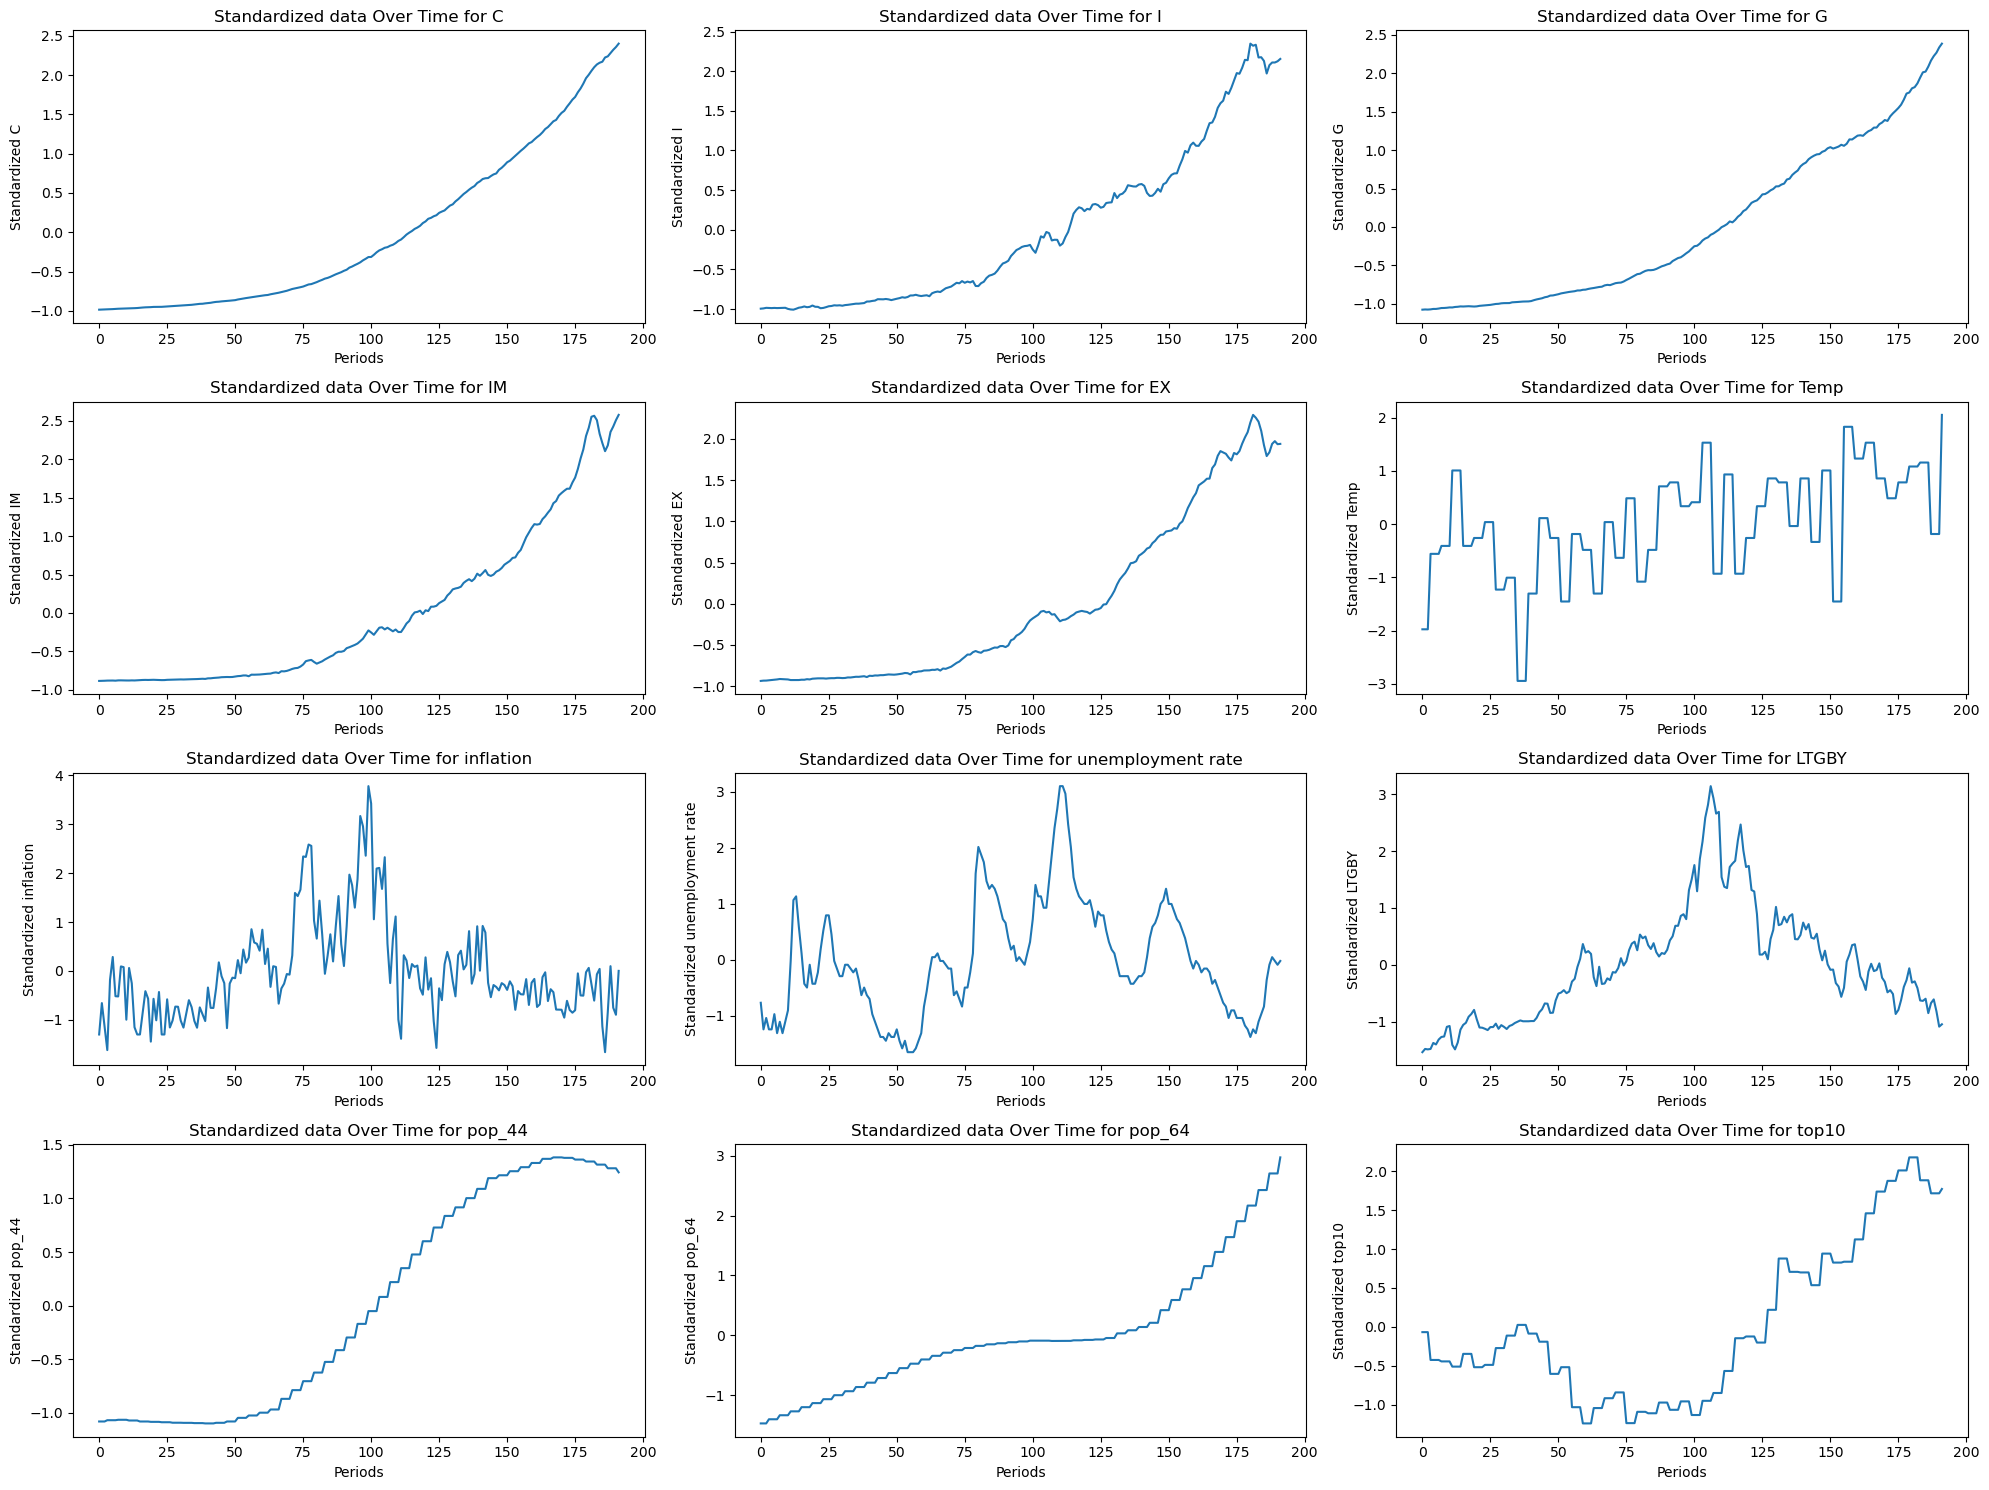

In [124]:

plt.figure(figsize=(20, 15))


plt.subplot(4, 3, 1) 
plt.plot(data['C'])
plt.ylabel('Standardized C')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for C')


plt.subplot(4, 3, 2) 
plt.plot(data['I'])
plt.ylabel('Standardized I')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for I')

plt.subplot(4, 3, 3)  
plt.plot(data['G'])
plt.ylabel('Standardized G')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for G')

plt.subplot(4, 3, 4)  
plt.plot(data['IM'])
plt.ylabel('Standardized IM')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for IM')

plt.subplot(4, 3, 5)  
plt.plot(data['EX'])
plt.ylabel('Standardized EX')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for EX')

plt.subplot(4, 3, 6)  
plt.plot(data['Temp'])
plt.ylabel('Standardized Temp')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for Temp')

plt.subplot(4, 3, 7)  
plt.plot(data['inflation'])
plt.ylabel('Standardized inflation')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for inflation')

plt.subplot(4, 3, 8)  
plt.plot(data['unemploy'])
plt.ylabel('Standardized unemployment rate')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for unemployment rate')

plt.subplot(4, 3, 9)  
plt.plot(data['LTGBY'])
plt.ylabel('Standardized LTGBY')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for LTGBY')

plt.subplot(4, 3, 10)  
plt.plot(data['pop_44'])
plt.ylabel('Standardized pop_44')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for pop_44')

plt.subplot(4, 3, 11)  
plt.plot(data['pop_64'])
plt.ylabel('Standardized pop_64')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for pop_64')

plt.subplot(4, 3, 12)  
plt.plot(data['top10'])
plt.ylabel('Standardized top10')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for top10')
# Display the plot
plt.tight_layout()  # Adjust layout to not overlap subplots
plt.show()


# See the problem?
**Some factors grow exponentially, which may influence the models' prediction because they don't share the same pattern throughout the history. To explaine it in a simplier way, some factors will grow really really fast in the future, but the algorithm cannot learn this pattern from the past data in the train set, leading to some major prediction errors**

# How to fix it?
**Try using the growth rate instead of the absolute value because growth rate are more steady throught the history, and let's do this**

# Column name discription
1. C        -   consumption growth 
2. I        -   investment growth 
3. G        -   government spending growth 
4. IM       -   import ammount growth 
5. EX       -   export ammount growth 
6. unemploy -   unemployment rate (%)
7. LTGBY    -   Long Term Government Bond Yield(10 years) (%)
8. pop_44   -   population growth of age group 25-44 
9. pop_64   -   population growth of age group 45-64 
10. top10   -   top 10% pre-tax national income share (%)
11. temp    -   average tempreture (Fahrenheit)
12. inflation - inflation rate (%)

# First let's visulize the growth rate to see if it is really more stable 

In [81]:
main_form = pd.read_csv("d:\econ1500\data\growth.csv")
# main_form.set_index('DATE', drop=False, inplace=True)
main_form = main_form.drop(['Year', 'DATE'], axis=1)

main_form_target = {}
main_form_features = {}
x_train = {}
x_val = {}
x_test = {}
y_train = {}
y_val = {}
y_test = {}

for i in main_form.columns:
    main_form_target[i] = main_form[[i]].shift(-1)
    main_form_features[i] = main_form
    # main_form_features[i] = main_form.drop([i], axis= 1)

    #determine train, val, and test size
    train_size = 0.7
    val_size = 0.15
    test_size = 0.15

    train_end = int(len(main_form[i]) * train_size)
    val_end = int(len(main_form[i]) * (train_size + val_size))
    #split data
    x_train[i] = main_form_features[i][:train_end]
    x_val[i] = main_form_features[i][train_end:val_end]
    x_test[i] = main_form_features[i][val_end:-1]
    y_train[i] = main_form_target[i][:train_end]
    y_val[i] = main_form_target[i][train_end:val_end]
    y_test[i] = main_form_target[i][val_end:-1]

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

for i in main_form.columns:
    imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
    X_impute = imputer.fit_transform(x_test[i])
    y_impute = imputer.fit_transform(y_test[i])
    x_test[i] = pd.DataFrame(data=X_impute, columns = x_test[i].columns)
    y_test[i] = pd.DataFrame(data=y_impute, columns = y_test[i].columns)

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
X_train_prep = {}
X_val_prep = {}
X_test_prep = {}
for i in main_form.columns:

    std_ftrs = x_train[i].columns.tolist()
    preprocessor = ColumnTransformer(
        transformers = [('std', StandardScaler(), std_ftrs)])


    clf = Pipeline(steps = [('preprocessor', preprocessor)])

    X_train_prep[i] = clf.fit_transform(x_train[i])
    X_val_prep[i] = clf.transform(x_val[i])
    X_test_prep[i] = clf.transform(x_test[i])

from matplotlib import pylab as plt
X_train_prep['C']
X_train_prep['C'].shape
data = {}
for b, i in enumerate(main_form.columns):
    data[i] = []
    for a in range(X_train_prep['C'].shape[0]):
        data[i].append(X_train_prep['C'][a][b])


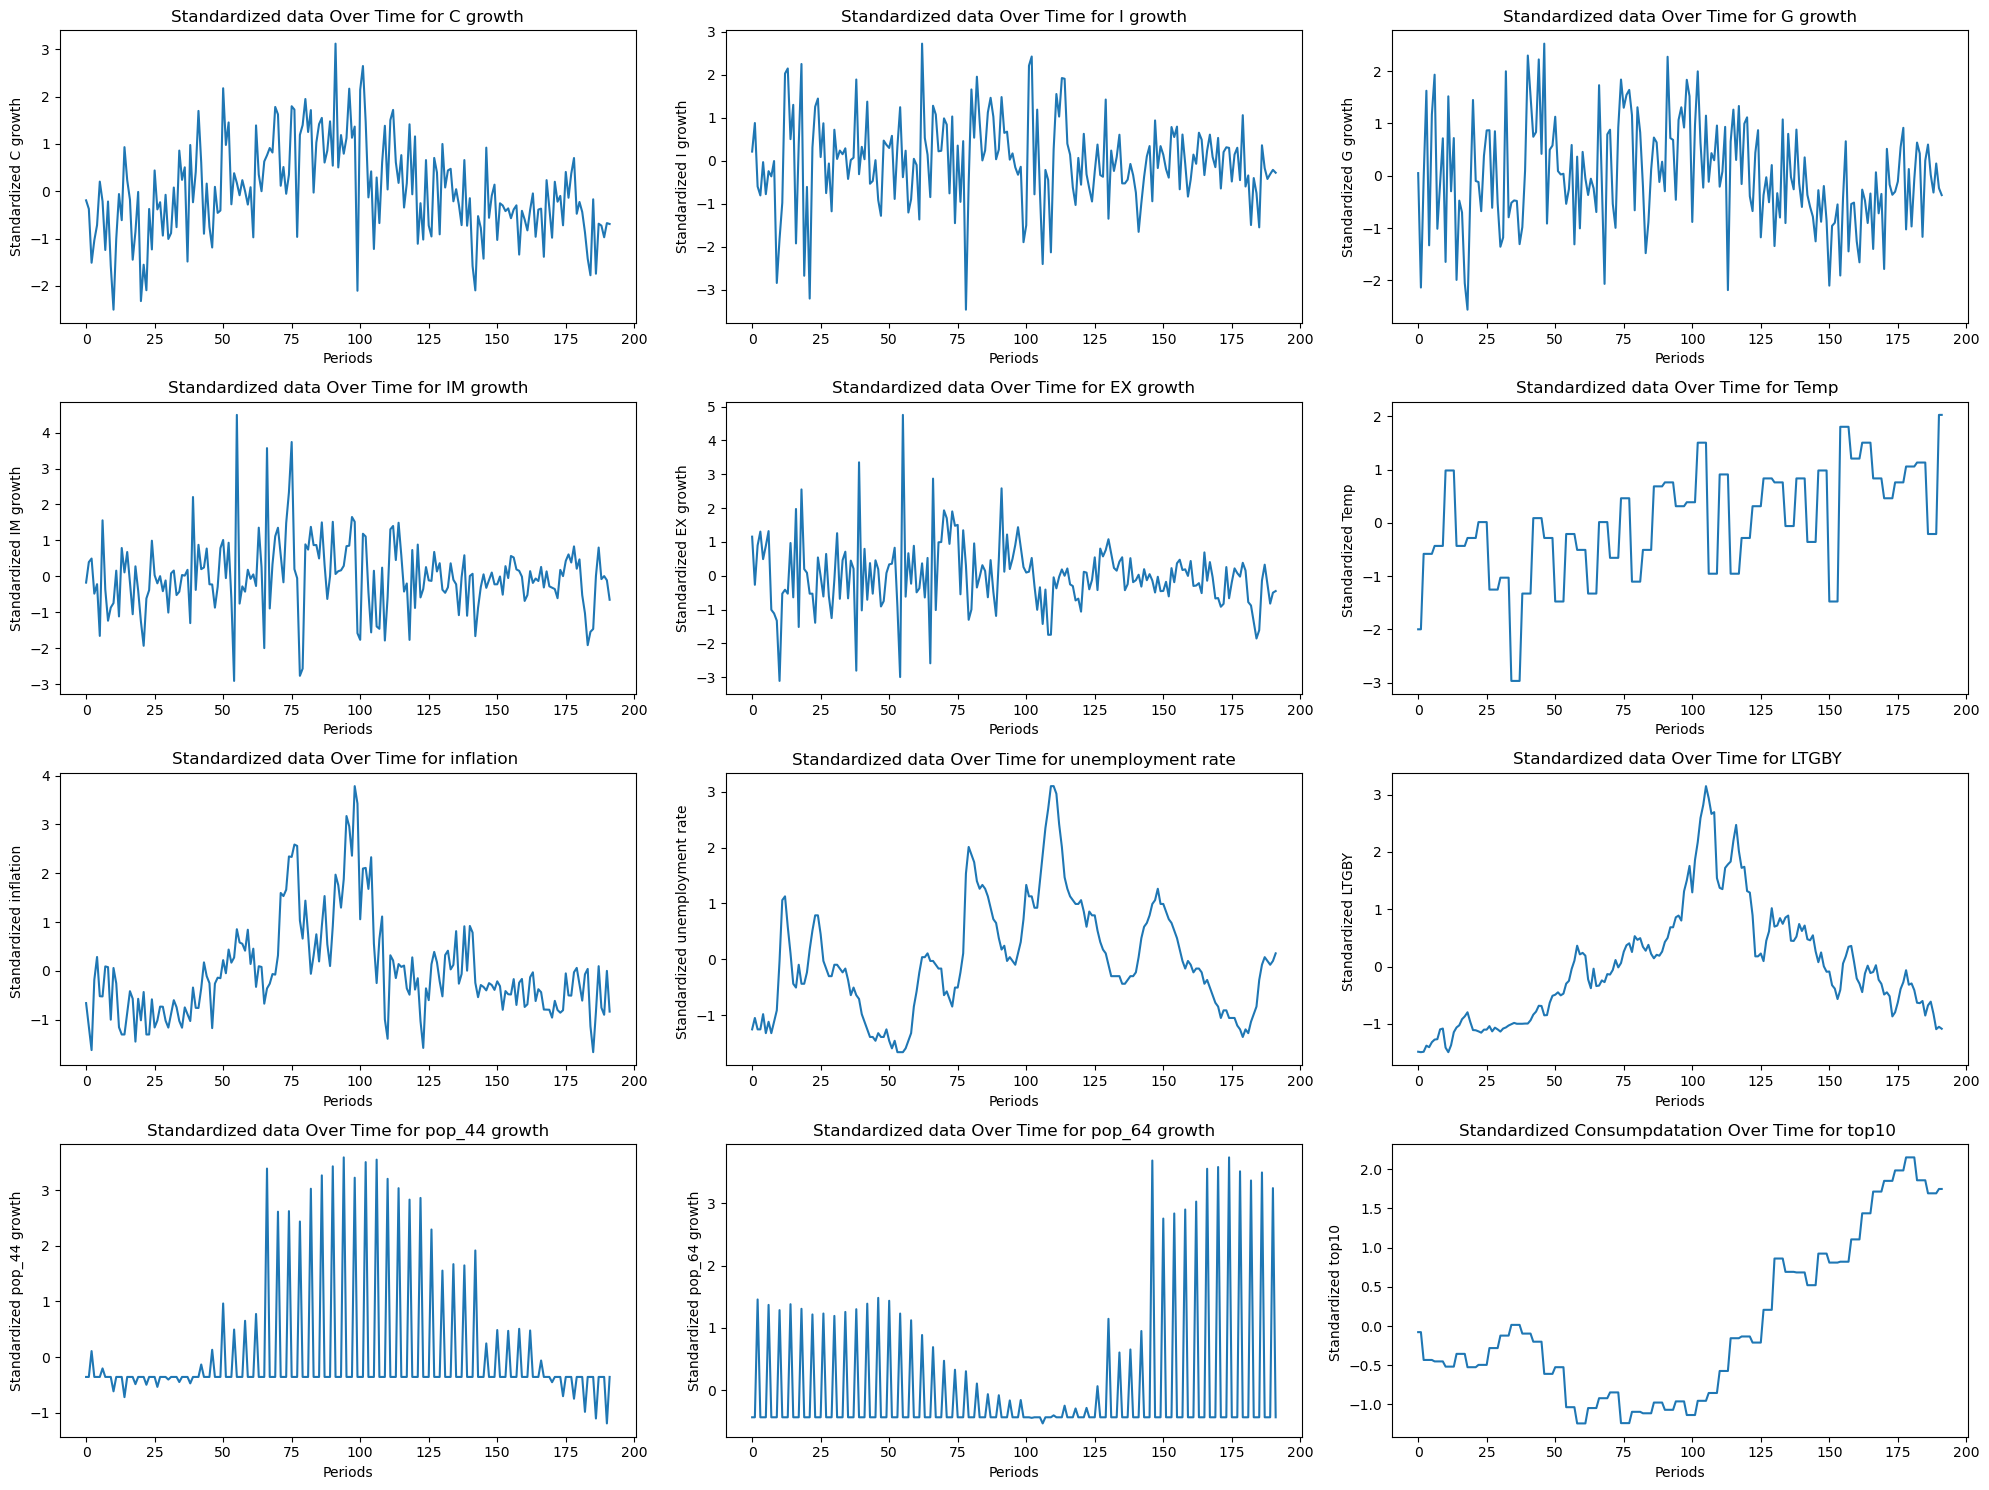

In [119]:

plt.figure(figsize=(20, 15))


plt.subplot(4, 3, 1) 
plt.plot(data['C'])
plt.ylabel('Standardized C growth')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for C growth')


plt.subplot(4, 3, 2) 
plt.plot(data['I'])
plt.ylabel('Standardized I growth')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for I growth')

plt.subplot(4, 3, 3)  
plt.plot(data['G'])
plt.ylabel('Standardized G growth')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for G growth')

plt.subplot(4, 3, 4)  
plt.plot(data['IM'])
plt.ylabel('Standardized IM growth')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for IM growth')

plt.subplot(4, 3, 5)  
plt.plot(data['EX'])
plt.ylabel('Standardized EX growth')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for EX growth')

plt.subplot(4, 3, 6)  
plt.plot(data['Temp'])
plt.ylabel('Standardized Temp ')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for Temp ')

plt.subplot(4, 3, 7)  
plt.plot(data['inflation'])
plt.ylabel('Standardized inflation ')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for inflation ')

plt.subplot(4, 3, 8)  
plt.plot(data['unemploy'])
plt.ylabel('Standardized unemployment rate ')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for unemployment rate')

plt.subplot(4, 3, 9)  
plt.plot(data['LTGBY'])
plt.ylabel('Standardized LTGBY ')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for LTGBY ')

plt.subplot(4, 3, 10)  
plt.plot(data['pop_44'])
plt.ylabel('Standardized pop_44 growth')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for pop_44 growth')

plt.subplot(4, 3, 11)  
plt.plot(data['pop_64'])
plt.ylabel('Standardized pop_64 growth')
plt.xlabel('Periods')
plt.title('Standardized data Over Time for pop_64 growth')

plt.subplot(4, 3, 12)  
plt.plot(data['top10'])
plt.ylabel('Standardized top10 ')
plt.xlabel('Periods')
plt.title('Standardized Consumpdatation Over Time for top10 ')
# Display the plot
plt.tight_layout()  # Adjust layout to not overlap subplots
plt.show()


# The exponential feature in the old dataset has been removed! Now let's train the model again and see if we can get a better prediction！
**The pop_44 and pop_64 data look a little bit weird because they are originally annual data. When transferred to quarter data, there existed many deplucate values and thus there are a lot of zeros in the growth rate... Anyway, we can just neglect it!**

# Calculate baseline MSE for each feature using the mean value of each feature

In [86]:
avg = {}
sum = {}
for i in main_form.columns:
    sum[i] = []
    avg[i] = np.nanmean(main_form[i].tolist())
    for row in range(main_form.shape[0]):
        temp = np.square(main_form[i][row] - avg[i])
        sum[i].append(temp)
    sum[i] = np.nanmean(sum[i])
print(sum)

0.015888821032846716
0.016433299284306573
0.014635131703284671
0.02086586605839416
0.020093434875912412
52.93284671532846
0.8986629229051094
5.874817518248175
5.66529197080292
0.0023931415145985397
0.003321601130656934
39.220888888888894
{'C': 0.00013942570792153423, 'I': 0.0018232935371653722, 'G': 0.0001276246155761592, 'IM': 0.001835747903518716, 'EX': 0.0018885648861745531, 'Temp': 3.114176567744687, 'inflation': 0.6445829784821459, 'unemploy': 2.9219570834887314, 'LTGBY': 8.438051192125313, 'pop_44': 7.522347708633277e-05, 'pop_64': 6.98908838290144e-05, 'top10': 19.076630320987654}


In [98]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
MSE_score = pd.DataFrame.from_dict(sum, orient='index', columns = ['Baseline'])
MSE_score

,Baseline
C,0.000139
I,0.001823
G,0.000128
IM,0.001836
EX,0.001889
Temp,3.114177
inflation,0.644583
unemploy,2.921957
LTGBY,8.438051
pop_44,0.000075


# Ridge Model
**Hyper-parameter to be tuned: alpha value**

In [89]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800]
param_grid = {'regressor__alpha': alpha_values}

train_rmse_score_ridge = np.zeros(len(ParameterGrid(param_grid)))
val_rmse_score_ridge = np.zeros(len(ParameterGrid(param_grid)))

test_rmse_scores_ridge = {}
final_models_ridge = {}
for i in main_form.columns:
    models = []
    base_rmse_test_ridge = []
    base_rmse_val_ridge = []
    val_rmse_scores_ridge = []

    print('---------------------------------------')
    print('Ridge model to predict', i)
    for p, params in enumerate(ParameterGrid(param_grid)):
            params = ParameterGrid(param_grid)[p]
            print('   ',params) 
            
            model = Ridge(alpha=params['regressor__alpha'], solver = 'saga' ,random_state=42, max_iter=10000)
            
            model.fit(X_train_prep[i],y_train[i]) 
            models.append(model) 
            
            y_train_pred = model.predict(X_train_prep[i])
            train_rmse_score_ridge[p] = mean_squared_error(y_train[i], y_train_pred)
            y_val_pred = model.predict(X_val_prep[i])
            val_rmse_score_ridge[p] = mean_squared_error(y_val[i], y_val_pred)
            print('   ', train_rmse_score_ridge[p],val_rmse_score_ridge[p])
    

   
    print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_rmse_score_ridge)])
    print('corresponding validation score:',np.min(val_rmse_score_ridge))
 

    
    final_models_ridge[i] = (models[np.argmin(val_rmse_score_ridge)])
    
    y_test_pred = final_models_ridge[i].predict(X_test_prep[i])
        
    test_rmse_scores_ridge[i] = mean_squared_error(y_test[i], y_test_pred)
    print('test score:',test_rmse_scores_ridge[i])
    

---------------------------------------
Ridge model to predict C
    {'regressor__alpha': 0.0001}
    4.291450146650243e-05 6.0783456655036035e-05
    {'regressor__alpha': 0.001}
    4.2914501465095085e-05 6.0783331617971795e-05
    {'regressor__alpha': 0.01}
    4.29145014678892e-05 6.078208177480628e-05
    {'regressor__alpha': 0.1}
    4.291450317909115e-05 6.076963593406455e-05
    {'regressor__alpha': 1}
    4.291468521183329e-05 6.065028435945157e-05
    {'regressor__alpha': 10}
    4.293031438141803e-05 5.985041720946941e-05
    {'regressor__alpha': 100}
    4.3650221546031904e-05 6.176566941865786e-05
    {'regressor__alpha': 150}
    4.419835909769405e-05 6.419935779475414e-05
    {'regressor__alpha': 200}
    4.4765228085847656e-05 6.668799030620418e-05
    {'regressor__alpha': 250}
    4.5327882025288054e-05 6.910957308065764e-05
    {'regressor__alpha': 300}
    4.587507548578522e-05 7.141964979923763e-05
    {'regressor__alpha': 350}
    4.6401242726882944e-05 7.3603072512

    1.2070300102043 1.687879652711235
    {'regressor__alpha': 700}
    1.259105016071638 1.7700108282130398
    {'regressor__alpha': 800}
    1.3029530761689532 1.8402212997424625
best model parameters: {'regressor__alpha': 100}
corresponding validation score: 1.0439821230025648
test score: 1.780283794816182
---------------------------------------
Ridge model to predict inflation
    {'regressor__alpha': 0.0001}
    0.16601433132951152 1.0220425566565947
    {'regressor__alpha': 0.001}
    0.16601433121996864 1.0220400420890114
    {'regressor__alpha': 0.01}
    0.16601433103882068 1.0220148941140803
    {'regressor__alpha': 0.1}
    0.16601442045749645 1.021763185592747
    {'regressor__alpha': 1}
    0.16602422499918065 1.0191593862145625
    {'regressor__alpha': 10}
    0.1668598702875924 0.9925106356103958
    {'regressor__alpha': 100}
    0.1976882558096024 0.7987783728883896
    {'regressor__alpha': 150}
    0.21672329942835503 0.7463471996217734
    {'regressor__alpha': 200}
  

**Store the MSE results in the table**

In [99]:
MSE_ridge = pd.DataFrame.from_dict(test_rmse_scores_ridge, orient='index', columns=['Ridge'])
MSE_score = MSE_score.join(MSE_ridge)
MSE_score


,Baseline,Ridge
C,0.000139,0.000566
I,0.001823,0.003153
G,0.000128,0.000067
IM,0.001836,0.003901
EX,0.001889,0.003217
Temp,3.114177,1.780284
inflation,0.644583,0.578808
unemploy,2.921957,3.924401
LTGBY,8.438051,0.730825
pop_44,0.000075,0.000123


**Store the best tuned hyper-parameter into the model**

In [91]:
final_models_ridge

{'C': Ridge(alpha=10, max_iter=10000, random_state=42, solver='saga'),
 'I': Ridge(alpha=100, max_iter=10000, random_state=42, solver='saga'),
 'G': Ridge(alpha=1, max_iter=10000, random_state=42, solver='saga'),
 'IM': Ridge(alpha=100, max_iter=10000, random_state=42, solver='saga'),
 'EX': Ridge(alpha=600, max_iter=10000, random_state=42, solver='saga'),
 'Temp': Ridge(alpha=100, max_iter=10000, random_state=42, solver='saga'),
 'inflation': Ridge(alpha=500, max_iter=10000, random_state=42, solver='saga'),
 'unemploy': Ridge(alpha=0.0001, max_iter=10000, random_state=42, solver='saga'),
 'LTGBY': Ridge(alpha=0.0001, max_iter=10000, random_state=42, solver='saga'),
 'pop_44': Ridge(alpha=200, max_iter=10000, random_state=42, solver='saga'),
 'pop_64': Ridge(alpha=700, max_iter=10000, random_state=42, solver='saga'),
 'top10': Ridge(alpha=0.0001, max_iter=10000, random_state=42, solver='saga')}

# Lasso Model
**Hyper-parameter to be tuned: alpha values**

In [92]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800]
param_grid = {'regressor__alpha': alpha_values}

train_rmse_score_ridge = np.zeros(len(ParameterGrid(param_grid)))
val_rmse_score_ridge = np.zeros(len(ParameterGrid(param_grid)))

param_grid = {'regressor__alpha': alpha_values}
test_rmse_scores_lasso = {}
final_models_lasso = {}
for i in main_form.columns:
    models = []
    base_rmse_test_lasso = []
    base_rmse_val_lasso = []
    val_rmse_scores_lasso = []

    print('---------------------------------------')
    print('Lasso model to predict', i)
    for p, params in enumerate(ParameterGrid(param_grid)):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
            
        model = Lasso(alpha=params['regressor__alpha'], selection = 'random' ,random_state=42, max_iter=100000)
            
        model.fit(X_train_prep[i],y_train[i]) 
        models.append(model) 
            
        y_train_pred = model.predict(X_train_prep[i])
        train_rmse_score_ridge[p] = mean_squared_error(y_train[i], y_train_pred)
        y_val_pred = model.predict(X_val_prep[i])
        val_rmse_score_ridge[p] = mean_squared_error(y_val[i], y_val_pred)
            
        print('   ', train_rmse_score_ridge[p],val_rmse_score_ridge[p])
        

    final_models_lasso[i] = (models[np.argmin(val_rmse_score_ridge)])
    print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_rmse_score_ridge)])
    print('corresponding validation score:',np.min(val_rmse_score_ridge))
 

    
    
    
    y_test_pred = final_models_lasso[i].predict(X_test_prep[i])
        
    test_rmse_scores_lasso[i] = mean_squared_error(y_test[i], y_test_pred)
    print('test score:',test_rmse_scores_lasso[i])
    

---------------------------------------
Lasso model to predict C
    {'regressor__alpha': 0.0001}
    4.299521314730369e-05 6.025253498135809e-05
    {'regressor__alpha': 0.001}
    4.646247413318262e-05 6.546210063300425e-05
    {'regressor__alpha': 0.01}
    6.148661974077025e-05 0.00012854389218844246
    {'regressor__alpha': 0.1}
    6.148661974077025e-05 0.00012854389218844246
    {'regressor__alpha': 1}
    6.148661974077025e-05 0.00012854389218844246
    {'regressor__alpha': 10}
    6.148661974077025e-05 0.00012854389218844246
    {'regressor__alpha': 100}
    6.148661974077025e-05 0.00012854389218844246
    {'regressor__alpha': 150}
    6.148661974077025e-05 0.00012854389218844246
    {'regressor__alpha': 200}
    6.148661974077025e-05 0.00012854389218844246
    {'regressor__alpha': 250}
    6.148661974077025e-05 0.00012854389218844246
    {'regressor__alpha': 300}
    6.148661974077025e-05 0.00012854389218844246
    {'regressor__alpha': 350}
    6.148661974077025e-05 0.0001285

    0.0014224752459273255 0.001725337610365684
    {'regressor__alpha': 0.1}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 1}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 10}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 100}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 150}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 200}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 250}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 300}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 350}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 400}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 450}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alpha': 500}
    0.0015837767053374717 0.0020586634734300713
    {'regressor__alp

**Store the MSE results into the table**

In [100]:
lasso_regre = pd.DataFrame.from_dict(test_rmse_scores_lasso, orient = 'index', columns=['Lasso'])
MSE_score = MSE_score.join(lasso_regre)
MSE_score

,Baseline,Ridge,Lasso
C,0.000139,0.000566,0.000562
I,0.001823,0.003153,0.004994
G,0.000128,0.000067,0.000062
IM,0.001836,0.003901,0.005030
EX,0.001889,0.003217,0.003142
Temp,3.114177,1.780284,0.971938
inflation,0.644583,0.578808,0.572641
unemploy,2.921957,3.924401,3.923437
LTGBY,8.438051,0.730825,0.731049
pop_44,0.000075,0.000123,0.000128


**Store the best tuned hyper-parameter into the model**

In [94]:
final_models_lasso

{'C': Lasso(alpha=0.0001, max_iter=100000, random_state=42, selection='random'),
 'I': Lasso(alpha=0.001, max_iter=100000, random_state=42, selection='random'),
 'G': Lasso(alpha=0.0001, max_iter=100000, random_state=42, selection='random'),
 'IM': Lasso(alpha=0.001, max_iter=100000, random_state=42, selection='random'),
 'EX': Lasso(alpha=0.01, max_iter=100000, random_state=42, selection='random'),
 'Temp': Lasso(alpha=0.1, max_iter=100000, random_state=42, selection='random'),
 'inflation': Lasso(alpha=0.1, max_iter=100000, random_state=42, selection='random'),
 'unemploy': Lasso(alpha=0.0001, max_iter=100000, random_state=42, selection='random'),
 'LTGBY': Lasso(alpha=0.001, max_iter=100000, random_state=42, selection='random'),
 'pop_44': Lasso(alpha=0.001, max_iter=100000, random_state=42, selection='random'),
 'pop_64': Lasso(alpha=0.01, max_iter=100000, random_state=42, selection='random'),
 'top10': Lasso(alpha=0.01, max_iter=100000, random_state=42, selection='random')}

# XGBoost Model
**Hyper-parameter to be tuned: learning rate, max_depth, n_estimators**

In [95]:
#XGBoost
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import warnings


warnings.filterwarnings('ignore', message='`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.', category=UserWarning)


param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1 , 2, 3, 4, 5],
    "missing": [np.nan], 
    'n_estimators': [25, 50, 100, 200], 
    'min_child_weight': [0.5, 1, 1.5, 2]
    
}


test_rmse_scores_xgb = {}
best_models_xgb = {}
for i in main_form.columns:
    print('---------------------------------------')
    print('XGBoost model to predict', i)

    model = XGBRegressor(eval_metric="rmse")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2)
    grid_search.fit(X_train_prep[i], y_train[i])

    
    best_model = grid_search.best_estimator_
    best_models_xgb[i] = best_model

   
    y_train_pred = best_model.predict(X_train_prep[i])
    y_val_pred = best_model.predict(X_val_prep[i])
    y_test_pred = best_model.predict(X_test_prep[i])
    
    train_rmse = mean_squared_error(y_train[i], y_train_pred)
    val_rmse = mean_squared_error(y_val[i], y_val_pred)
    test_rmse = mean_squared_error(y_test[i], y_test_pred)

    test_rmse_scores_xgb[i] = test_rmse


    print('Train RMSE:', train_rmse)
    print('Validation RMSE:', val_rmse)
    print('Test RMSE:', test_rmse)

    print('Best model parameters:', grid_search.best_params_)
    print('Corresponding validation score:', grid_search.best_score_)
    



    

---------------------------------------
XGBoost model to predict C


Train RMSE: 7.435845987945265e-06
Validation RMSE: 9.969364378428067e-05
Test RMSE: 0.0005097246435934997
Best model parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1.5, 'missing': nan, 'n_estimators': 50}
Corresponding validation score: -0.008606337678992514
---------------------------------------
XGBoost model to predict I
Train RMSE: 0.0014032030425053033
Validation RMSE: 0.0012469370725188204
Test RMSE: 0.0017378067682656396
Best model parameters: {'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1.5, 'missing': nan, 'n_estimators': 50}
Corresponding validation score: -0.04364348375038665
---------------------------------------
XGBoost model to predict G
Train RMSE: 0.00010905140647138008
Validation RMSE: 0.00011215850117931173
Test RMSE: 9.501656582687866e-05
Best model parameters: {'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 0.5, 'missing': nan, 'n_estimators': 25}
Corresponding validation score: -0.012334668082369528
----------------

**Store the MSE results into the table**

In [101]:
xgb = pd.DataFrame.from_dict(test_rmse_scores_xgb, orient = 'index', columns=['XGBoost'])

MSE_score = MSE_score.join(xgb)

MSE_score

,Baseline,Ridge,Lasso,XGBoost
C,0.000139,0.000566,0.000562,0.000510
I,0.001823,0.003153,0.004994,0.001738
G,0.000128,0.000067,0.000062,0.000095
IM,0.001836,0.003901,0.005030,0.002139
EX,0.001889,0.003217,0.003142,0.002358
Temp,3.114177,1.780284,0.971938,5.024929
inflation,0.644583,0.578808,0.572641,0.456273
unemploy,2.921957,3.924401,3.923437,2.912167
LTGBY,8.438051,0.730825,0.731049,2.644777
pop_44,0.000075,0.000123,0.000128,0.000110


**Store the best tuned hyper-parameter into the model**

In [102]:
best_models_xgb

{'C': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1.5, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...),
 'I': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='r

# SVR model
**Hyper parameter to be tuned: C value, gamma value and kernel type**

In [103]:
from sklearn.svm import SVR


param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 0.5],
    'kernel': ['rbf', 'linear']
}


test_rmse_scores_svr = {}
best_models_svr = {}
for i in main_form.columns:
    print('---------------------------------------')
    print('SVR model to predict', i)

    model = SVR()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2)
    grid_search.fit(X_train_prep[i], y_train[i].values.ravel())

    
    best_model = grid_search.best_estimator_
    best_models_svr[i] = best_model

   
    y_train_pred = best_model.predict(X_train_prep[i])
    y_val_pred = best_model.predict(X_val_prep[i])
    y_test_pred = best_model.predict(X_test_prep[i])
    
    train_rmse = mean_squared_error(y_train[i].values.ravel(), y_train_pred)
    val_rmse = mean_squared_error(y_val[i].values.ravel(), y_val_pred)
    test_rmse = mean_squared_error(y_test[i].values.ravel(), y_test_pred)

    test_rmse_scores_svr[i] = test_rmse


    print('Train RMSE:', train_rmse)
    print('Validation RMSE:', val_rmse)
    print('Test RMSE:', test_rmse)

    print('Best model parameters:', grid_search.best_params_)
    print('Corresponding validation score:', grid_search.best_score_)
    



    

---------------------------------------
SVR model to predict C
Train RMSE: 6.722063463872639e-05
Validation RMSE: 0.00017410164250246545
Test RMSE: 0.0005737920644977546
Best model parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Corresponding validation score: -0.00817694234949454
---------------------------------------
SVR model to predict I
Train RMSE: 0.001773304110637144
Validation RMSE: 0.0013330849308504636
Test RMSE: 0.0017737048741045898
Best model parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Corresponding validation score: -0.042411957126891185
---------------------------------------
SVR model to predict G
Train RMSE: 0.0001394683541663693
Validation RMSE: 0.00013340490098130584
Test RMSE: 9.028713446610315e-05
Best model parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Corresponding validation score: -0.011794666509089759
---------------------------------------
SVR model to predict IM


Train RMSE: 0.0015557513499356024
Validation RMSE: 0.0028457588989621737
Test RMSE: 0.004060801949087131
Best model parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Corresponding validation score: -0.042661281780715314
---------------------------------------
SVR model to predict EX
Train RMSE: 0.0016227678823070898
Validation RMSE: 0.001287368544429239
Test RMSE: 0.0028802316830278643
Best model parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Corresponding validation score: -0.041742539686427174
---------------------------------------
SVR model to predict Temp
Train RMSE: 0.6449698075637476
Validation RMSE: 1.1289286876182452
Test RMSE: 0.41273630095258884
Best model parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Corresponding validation score: -0.8409131874341949
---------------------------------------
SVR model to predict inflation
Train RMSE: 0.16014620016587494
Validation RMSE: 0.684719582854725
Test RMSE: 0.4655524558625274
Best model parameters: {'C': 1, 'g

**Store the MSE results into the table**

In [104]:
svr = pd.DataFrame.from_dict(test_rmse_scores_svr, orient = 'index', columns=['SVR'])

MSE_score = MSE_score.join(svr)

MSE_score

,Baseline,Ridge,Lasso,XGBoost,SVR
C,0.000139,0.000566,0.000562,0.000510,0.000574
I,0.001823,0.003153,0.004994,0.001738,0.001774
G,0.000128,0.000067,0.000062,0.000095,0.000090
IM,0.001836,0.003901,0.005030,0.002139,0.004061
EX,0.001889,0.003217,0.003142,0.002358,0.002880
Temp,3.114177,1.780284,0.971938,5.024929,0.412736
inflation,0.644583,0.578808,0.572641,0.456273,0.465552
unemploy,2.921957,3.924401,3.923437,2.912167,2.968520
LTGBY,8.438051,0.730825,0.731049,2.644777,0.574692
pop_44,0.000075,0.000123,0.000128,0.000110,0.000194


**Store the best tuned hyper-parameter into the model**

In [105]:
best_models_svr

{'C': SVR(C=0.1, gamma=0.01),
 'I': SVR(C=0.1, gamma=0.01),
 'G': SVR(C=0.1, gamma=0.01),
 'IM': SVR(C=0.1, gamma=0.1),
 'EX': SVR(C=0.1, gamma=0.01),
 'Temp': SVR(C=0.1, gamma=0.01, kernel='linear'),
 'inflation': SVR(C=1, gamma=0.01),
 'unemploy': SVR(C=10, gamma=0.01),
 'LTGBY': SVR(C=10, gamma=0.01, kernel='linear'),
 'pop_44': SVR(C=0.1, gamma=0.01),
 'pop_64': SVR(C=0.1, gamma=0.01),
 'top10': SVR(C=10, gamma=0.01, kernel='linear')}

# Random Forest
**Hyper-parameters to be tuned: max features, max depth**

In [106]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
              'max_features': [None,1, 3, 10, 20], 
              'max_depth': [None,1, 3, 10, 20]
              } 


test_rmse_scores_rf = {}
best_models_rf = {}
for i in main_form.columns:
    print('---------------------------------------')
    print('RF model to predict', i)

    model = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2)
    grid_search.fit(X_train_prep[i], y_train[i].values.ravel())

    
    best_model = grid_search.best_estimator_
    best_models_rf[i] = best_model

   
    y_train_pred = best_model.predict(X_train_prep[i])
    y_val_pred = best_model.predict(X_val_prep[i])
    y_test_pred = best_model.predict(X_test_prep[i])
    
    train_rmse = mean_squared_error(y_train[i].values.ravel(), y_train_pred)
    val_rmse = mean_squared_error(y_val[i].values.ravel(), y_val_pred)
    test_rmse = mean_squared_error(y_test[i].values.ravel(), y_test_pred)

    test_rmse_scores_rf[i] = test_rmse


    print('Train RMSE:', train_rmse)
    print('Validation RMSE:', val_rmse)
    print('Test RMSE:', test_rmse)

    print('Best model parameters:', grid_search.best_params_)
    print('Corresponding validation score:', grid_search.best_score_)

---------------------------------------
RF model to predict C


Train RMSE: 3.0064711146375252e-05
Validation RMSE: 8.61623940128548e-05
Test RMSE: 0.0005139056751418037
Best model parameters: {'max_depth': 3, 'max_features': 3}
Corresponding validation score: -0.007191833020016145
---------------------------------------
RF model to predict I
Train RMSE: 0.0012740129062815794
Validation RMSE: 0.001271263959170987
Test RMSE: 0.0017386139617956552
Best model parameters: {'max_depth': 3, 'max_features': 3}
Corresponding validation score: -0.042076898160563085
---------------------------------------
RF model to predict G
Train RMSE: 0.00010215211040888248
Validation RMSE: 0.00011210846618988794
Test RMSE: 7.645751198994576e-05
Best model parameters: {'max_depth': 3, 'max_features': 1}
Corresponding validation score: -0.011569325963828507
---------------------------------------
RF model to predict IM
Train RMSE: 0.0007911462104877057
Validation RMSE: 0.0029041165444869763
Test RMSE: 0.0018665634088606106
Best model parameters: {'max_depth': 3, 'max_feat

**Store the MSE results into the table**

In [107]:
rf = pd.DataFrame.from_dict(test_rmse_scores_rf, orient = 'index', columns=['Random Forest'])

MSE_score = MSE_score.join(rf)

MSE_score

,Baseline,Ridge,Lasso,XGBoost,SVR,Random Forest
C,0.000139,0.000566,0.000562,0.000510,0.000574,0.000514
I,0.001823,0.003153,0.004994,0.001738,0.001774,0.001739
G,0.000128,0.000067,0.000062,0.000095,0.000090,0.000076
IM,0.001836,0.003901,0.005030,0.002139,0.004061,0.001867
EX,0.001889,0.003217,0.003142,0.002358,0.002880,0.002441
Temp,3.114177,1.780284,0.971938,5.024929,0.412736,2.813778
inflation,0.644583,0.578808,0.572641,0.456273,0.465552,0.442234
unemploy,2.921957,3.924401,3.923437,2.912167,2.968520,3.063557
LTGBY,8.438051,0.730825,0.731049,2.644777,0.574692,1.536254
pop_44,0.000075,0.000123,0.000128,0.000110,0.000194,0.000103


**Store the best tuned hyper-parameter into the model**

In [108]:
best_models_rf

{'C': RandomForestRegressor(max_depth=3, max_features=3),
 'I': RandomForestRegressor(max_depth=3, max_features=3),
 'G': RandomForestRegressor(max_depth=3, max_features=1),
 'IM': RandomForestRegressor(max_depth=3, max_features=None),
 'EX': RandomForestRegressor(max_depth=10, max_features=1),
 'Temp': RandomForestRegressor(max_depth=10, max_features=None),
 'inflation': RandomForestRegressor(max_depth=10, max_features=3),
 'unemploy': RandomForestRegressor(max_depth=10, max_features=None),
 'LTGBY': RandomForestRegressor(max_depth=10, max_features=None),
 'pop_44': RandomForestRegressor(max_depth=3, max_features=1),
 'pop_64': RandomForestRegressor(max_depth=3, max_features=1),
 'top10': RandomForestRegressor(max_depth=3, max_features=20)}

# 1D-Convolutional Neural Network Model(1D-CNN)
**Hyper-parameter to be tuned: number of filters, kernel size**

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier, KerasRegressor

**Preprocess the train, val, test data to fit the shape requirement of 1D-CNN**

In [110]:
time_steps = 10
X={}
y={}
X_val_NN = {}
y_val_NN = {}
X_test_NN = {}
y_test_NN = {}

for i in main_form.columns:
    # X[i]={}
    # y[i]={}
    
    X[i] = []
    y[i] = []
    X_val_NN[i] = []
    y_val_NN[i] = []
    X_test_NN[i] = []
    y_test_NN[i] = []
    y_train_list = y_train[i][i].tolist()
    y_val_list = y_val[i][i].tolist()
    y_test_list = y_test[i][i].tolist()
    for time in range(time_steps, len(X_train_prep[i])):
        X[i].append(X_train_prep[i][time-time_steps:time])  
        y[i].append(y_train_list[time])  
    for time in range(time_steps, len(X_val_prep[i])):
        X_val_NN[i].append(X_val_prep[i][time-time_steps:time])  
        y_val_NN[i].append(y_val_list[time])
    for time in range(time_steps, len(X_test_prep[i])):
        X_test_NN[i].append(X_test_prep[i][time-time_steps:time])  
        y_test_NN[i].append(y_test_list[time])

    X[i] = np.array(X[i])
    y[i] = np.array(y[i])
    X_val_NN[i] = np.array(X_val_NN[i])
    y_val_NN[i] = np.array(y_val_NN[i])
    X_test_NN[i] = np.array(X_test_NN[i])
    y_test_NN[i] = np.array(y_test_NN[i])

In [111]:
# X['I'].shape

In [112]:
# X_test_NN['I']

**Train 1D-CNN**

In [113]:
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Your code here (e.g., model training, evaluation, etc.)
best_models_CNN = {}
CNN_loss = {}

def create_model(filters=256, kernel_size=3):
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X[next(iter(X))].shape[1], X[next(iter(X))].shape[2])),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss=rmse)
    return model

model = KerasRegressor(build_fn=create_model, epochs=15, verbose=0, filters=128, kernel_size=3)

param_grid = {
    'filters': [32, 64, 128, 256, 512],
    'kernel_size': [1, 2, 3, 4, 5]
}

grid_result = {}
for i in main_form.columns:
    print('Predicting', i, 'using CNN with GridSearchCV')
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2, scoring='neg_mean_squared_error')
    grid_result[i] = grid.fit(X[i], y[i])
    print(f'Best Score: {grid_result[i].best_score_} for {i} using {grid_result[i].best_params_}')

    best_model = grid_result[i].best_estimator_
    best_models_CNN[i] = best_model
    test_pred= best_models_CNN[i].predict(X_test_NN[i])
    test_rmse = mean_squared_error(y_test_NN[i], test_pred)
    CNN_loss[i] = test_rmse
    print('test loss is', CNN_loss[i])
    print()
    






Predicting C using CNN with GridSearchCV
Best Score: -8.564222261838025e-05 for C using {'filters': 512, 'kernel_size': 4}
test loss is 0.0007104060364181953

Predicting I using CNN with GridSearchCV
Best Score: -0.0018441873898546015 for I using {'filters': 512, 'kernel_size': 2}
test loss is 0.002345592683791364

Predicting G using CNN with GridSearchCV
Best Score: -0.0001188067881514277 for G using {'filters': 512, 'kernel_size': 3}
test loss is 6.679423894385576e-05

Predicting IM using CNN with GridSearchCV
Best Score: -0.0015932994350561407 for IM using {'filters': 512, 'kernel_size': 3}
test loss is 0.0040476047744605346

Predicting EX using CNN with GridSearchCV
Best Score: -0.0018399283607163541 for EX using {'filters': 512, 'kernel_size': 1}
test loss is 0.004722767094240383

Predicting Temp using CNN with GridSearchCV
Best Score: -166.35113903410436 for Temp using {'filters': 32, 'kernel_size': 1}
test loss is 1126.8841279428386

Predicting inflation using CNN with GridSearc

**Store the MSE results into the table**

In [114]:
NN_loss = pd.DataFrame.from_dict(CNN_loss, orient = 'index', columns = ['CNN'])
MSE_score = MSE_score.join(NN_loss)
MSE_score

,Baseline,Ridge,Lasso,XGBoost,SVR,Random Forest,CNN
C,0.000139,0.000566,0.000562,0.000510,0.000574,0.000514,0.000710
I,0.001823,0.003153,0.004994,0.001738,0.001774,0.001739,0.002346
G,0.000128,0.000067,0.000062,0.000095,0.000090,0.000076,0.000067
IM,0.001836,0.003901,0.005030,0.002139,0.004061,0.001867,0.004048
EX,0.001889,0.003217,0.003142,0.002358,0.002880,0.002441,0.004723
Temp,3.114177,1.780284,0.971938,5.024929,0.412736,2.813778,1126.884128
inflation,0.644583,0.578808,0.572641,0.456273,0.465552,0.442234,0.442071
unemploy,2.921957,3.924401,3.923437,2.912167,2.968520,3.063557,36.991931
LTGBY,8.438051,0.730825,0.731049,2.644777,0.574692,1.536254,52.676042
pop_44,0.000075,0.000123,0.000128,0.000110,0.000194,0.000103,0.000148


**Store the best tuned hyper-parameter into the model**

In [115]:
best_models_CNN

{'C': KerasRegressor(
 	model=None
 	build_fn=<function create_model at 0x00000212927D80E0>
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=None
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=15
 	filters=512
 	kernel_size=4
 ),
 'I': KerasRegressor(
 	model=None
 	build_fn=<function create_model at 0x00000212927D80E0>
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=None
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=15
 	filters=512
 	kernel_size=2
 ),
 'G': KerasRegressor(
 	model=None
 	build_fn=<function create_model at 0x00000212927D80E0>
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=None
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuff

# Let's have a look at the result here:

In [125]:
MSE_score

,Baseline,Ridge,Lasso,XGBoost,SVR,Random Forest,CNN
C,0.000139,0.000566,0.000562,0.000510,0.000574,0.000514,0.000710
I,0.001823,0.003153,0.004994,0.001738,0.001774,0.001739,0.002346
G,0.000128,0.000067,0.000062,0.000095,0.000090,0.000076,0.000067
IM,0.001836,0.003901,0.005030,0.002139,0.004061,0.001867,0.004048
EX,0.001889,0.003217,0.003142,0.002358,0.002880,0.002441,0.004723
Temp,3.114177,1.780284,0.971938,5.024929,0.412736,2.813778,1126.884128
inflation,0.644583,0.578808,0.572641,0.456273,0.465552,0.442234,0.442071
unemploy,2.921957,3.924401,3.923437,2.912167,2.968520,3.063557,36.991931
LTGBY,8.438051,0.730825,0.731049,2.644777,0.574692,1.536254,52.676042
pop_44,0.000075,0.000123,0.000128,0.000110,0.000194,0.000103,0.000148


**Although the MSE dropped a lot, which seems to be a good news, when compared to the baseline MSE, the performance are even worse. Maybe there are still other problems in the model...**

# This is the end of part2... But you can go to project_part3.ipynb if you still have any interest...